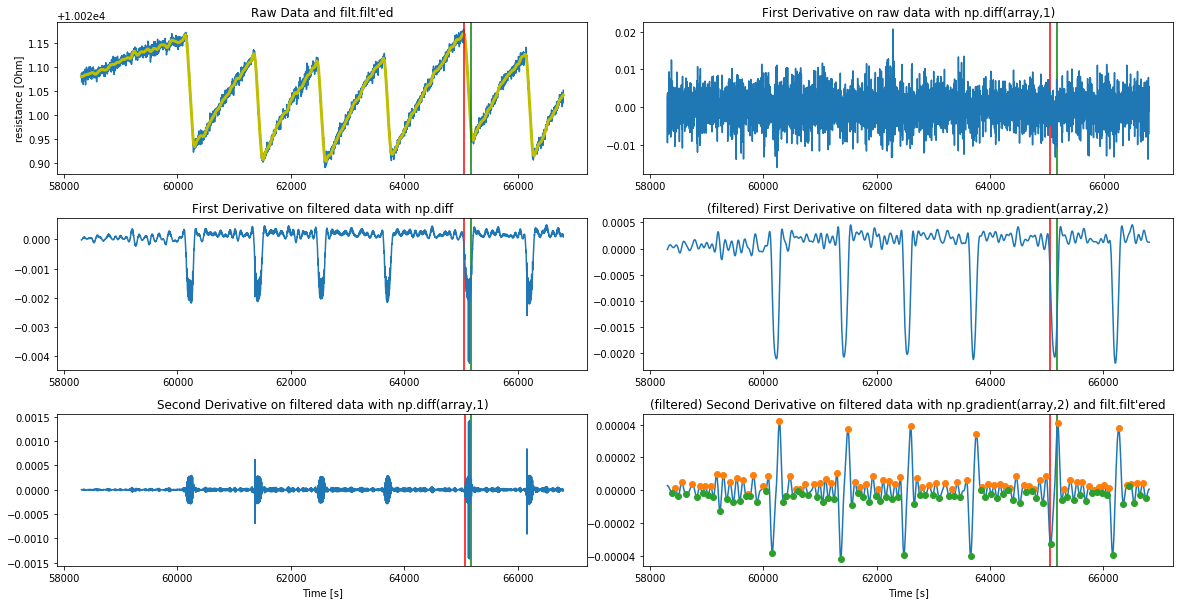

In [15]:
import numpy as np
import matplotlib.pyplot as pyplt
import matplotlib

dirname = "."
# filtration of noise inspired by https://stackoverflow.com/questions/28536191/how-to-filter-smooth-with-scipy-numpy
# See also the documentation on filtfilt here
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.filtfilt.html
from scipy.signal import butter, filtfilt, argrelextrema

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    sm_y = filtfilt(b, a, data)
    return sm_y

# Parameters used for the filtration of noisy data
cutoff = 1500
fs = 50000

fig = pyplt.figure(figsize=(10.0,3.0))
fig.tight_layout()

Core_data = np.loadtxt(fname='2015_12_22_15_44_20_strip.dat', skiprows=1)
data = Core_data[-5000:-1000][:]
time = data[:,0]
resistance = data[:,1]

#Smoothing of resistance data using filtfilt.
y_smooth = butter_lowpass_filtfilt(resistance, cutoff, fs=60000)

# By finite differences, the first order derivative of the smoothed y axes for each mean value of x over your array is given by:
dy=np.diff(y_smooth,1) # note that the first derivative is calculated over y_smooth, *not* resistance
dx=np.diff(time,1)

dy_raw = np.diff(resistance,1)
dy_smooth_gradient=np.gradient(y_smooth,4)
dx_gradient=np.gradient(time,4)

#dx=np.gradient(time,1)
yfirst=dy/dx
yfirst_raw=dy_raw/dx
yfirst_gradient = dy_smooth_gradient/dx_gradient
yfirst_gradient = butter_lowpass_filtfilt(yfirst_gradient, cutoff=1500, fs=60000)

# [...] the corresponding values of x are 
xfirst=0.5*(time[:-1]+time[1:])

# Should one need to smooth the first derivative as well
yfirst_smooth = butter_lowpass_filtfilt(yfirst, cutoff=1500, fs=10000)

# For the second order, do the same process again
dyfirst=np.diff(yfirst,1)
dxfirst=np.diff(xfirst,1)
ysecond=dyfirst/dxfirst

dyfirst_gradient = np.gradient(yfirst_gradient,3)
dxfirst_gradient = np.gradient(time,3)
ysecond_gradient = dyfirst_gradient/dxfirst_gradient
ysecond_gradient = butter_lowpass_filtfilt(ysecond_gradient, cutoff=1500, fs=60000)

maxima = argrelextrema(ysecond_gradient, np.greater)
minima = argrelextrema(ysecond_gradient, np.less)

# the corresponding values of x are: 
xsecond=0.5*(xfirst[:-1]+xfirst[1:])

# create a grid for the plots and arrangements of plots
f = pyplt.figure(figsize=(20,10))
gs = matplotlib.gridspec.GridSpec(6, 6, hspace=0.8, wspace=0.4)

ax1 = f.add_subplot(gs[:2,:3])
ax2 = f.add_subplot(gs[2:4,:3])
ax3 = f.add_subplot(gs[4:6,:3])
ax4 = f.add_subplot(gs[:2,3:6])
ax5 = f.add_subplot(gs[2:4,3:6])
ax6 = f.add_subplot(gs[4:6,3:6])

#Populating the plots
#ax1: original data plus smoothing
ax1.plot(time,resistance)
ax1.set_ylabel("resistance [Ohm]")
ax1.set_title("Raw Data and filt.filt'ed")
ax1.plot(time,y_smooth, color='y', linewidth=3.0)

ax1.axvline(x=65062, color='r')
ax2.axvline(x=65062, color='r')
ax3.axvline(x=65062, color='r')
ax4.axvline(x=65062, color='r')
ax5.axvline(x=65062, color='r')
ax6.axvline(x=65062, color='r')

ax1.axvline(x=65182, color='green')
ax2.axvline(x=65182, color='green')
ax3.axvline(x=65182, color='green')
ax4.axvline(x=65182, color='green')
ax5.axvline(x=65182, color='green')
ax6.axvline(x=65182, color='green')

#ax2.set_title("Original data, smoothed using filt.filt")
#ax2.plot(time,y_smooth)

ax2.plot(xfirst,yfirst)
#ax3.plot(time,yfirst)
#ax2.set_ylabel("dy/dx")
#ax2.set_xlabel("Time [s]")
ax2.set_title("First Derivative on filtered data with np.diff")

ax3.plot(xsecond,ysecond)
#ax4.plot(time,ysecond)
#ax3.set_ylabel("d2y/d2x")
ax3.set_xlabel("Time [s]")
ax3.set_title("Second Derivative on filtered data with np.diff(array,1)")

ax4.set_title("First Derivative on raw data with np.diff(array,1)")
ax4.plot(xfirst,yfirst_raw)

ax5.plot(time, yfirst_gradient)
ax5.set_title("(filtered) First Derivative on filtered data with np.gradient(array,2)")

ax6.set_xlabel("Time [s]")
ax6.plot(time, ysecond_gradient)
ax6.plot(time[maxima],ysecond_gradient[maxima], marker='o', linestyle='None')
ax6.plot(time[minima],ysecond_gradient[minima], marker='o', linestyle='None')

ax6.set_title("(filtered) Second Derivative on filtered data with np.gradient(array,2) and filt.filt'ered")

pyplt.savefig(dirname+"/"+"derivate_filters"+".png")
pyplt.show()


## Selection of "correct" maxima and minima
At this point we have a series of maxima and minima, but only the **larger** maxima and minima, in module, are the ones poiting at the end and the beginning of the heating runs, respectively. The smaller maxima and minima in between are artefact of the filtering that was applied to the data. What you really need then is to make a selection of those maxima and minima that will point you to the heating runs.
Let's first try with a selection based on the value of the maxima and the minima.

<function matplotlib.pyplot.plot>

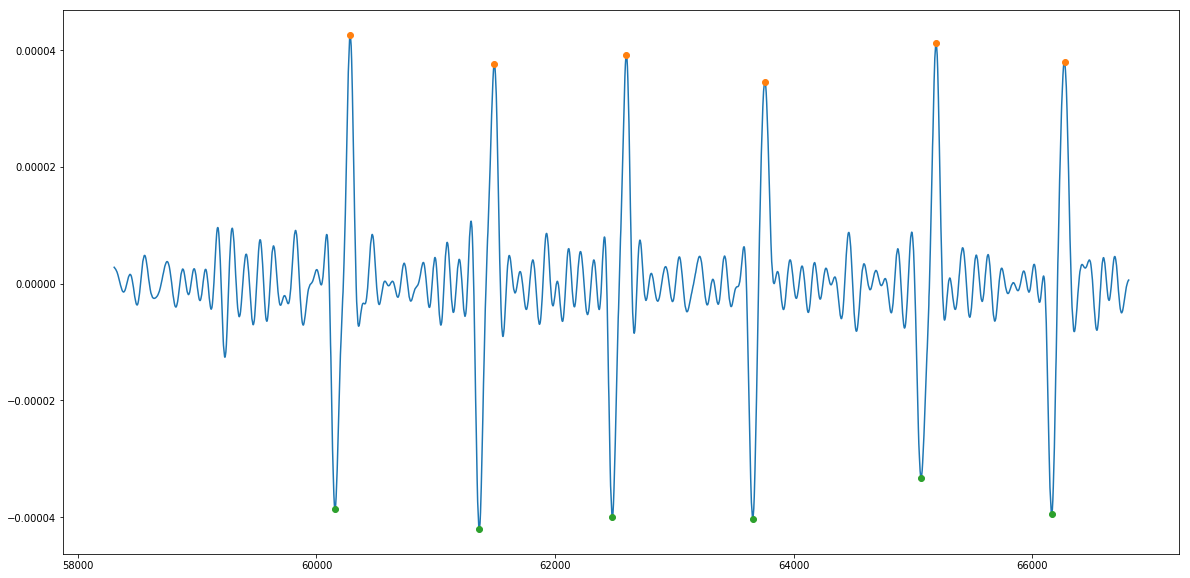

In [43]:
ymins = ysecond_gradient[minima]
tmins = time[minima]
ymaxs = ysecond_gradient[maxima]
tmaxs = time[maxima]

mins = ymins < -2.0e-5 # Selecting the 'real' minima
maxs = ymaxs > 2.0e-5
%matplotlib inline
pyplt.figure(figsize=(20,10))
pyplt.plot(time, ysecond_gradient)
pyplt.plot(tmaxs[maxs],ymaxs[maxs], marker='o', linestyle='None')
pyplt.plot(tmins[mins],ymins[mins], marker='o', linestyle='None')
pyplt.plot

In [45]:
tmins[mins]

array([ 60157.,  61364.,  62480.,  63656.,  65068.,  66160.])

In [46]:
tmaxs[maxs]

array([ 60282.,  61492.,  62597.,  63758.,  65193.,  66269.])

In [47]:
tmaxs[maxs] - tmins[mins]

array([ 125.,  128.,  117.,  102.,  125.,  109.])